In [25]:
import numpy as np
import pandas as pd
import SimpleITK as sitk
import os, sys, glob, re

import gui
import registration_gui as rgui

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
path_fixed_images = "CT_only_portal"
path_moving_images = "CT_only_artery"
path_fixed_masks = "mask_only_portal"
path_moving_masks = "mask_only_artery"

In [26]:
fixed = sitk.ReadImage(os.path.join(path_fixed_images, "789_40695855_resize.hdr"), 
                       sitk.sitkFloat32);
moving = sitk.ReadImage(os.path.join(path_moving_images, "789_40695855_resize.hdr"), 
                        sitk.sitkFloat32)
mask_fixed = sitk.ReadImage(os.path.join(path_fixed_masks, "789_40695855_resize_Lg.hdr"), 
                            sitk.sitkUInt8)
mask_moving= sitk.ReadImage(os.path.join(path_moving_masks, "789_40695855_resize_Lg.hdr"), 
                            sitk.sitkUInt8)

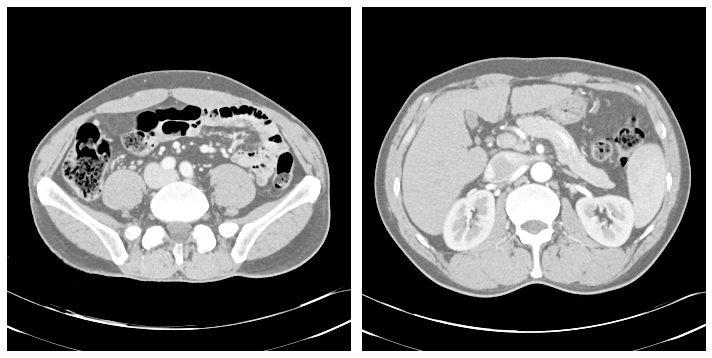

In [40]:
ct_window_level = [550, -50]
gui.MultiImageDisplay(image_list = [fixed, moving], window_level_list=[ct_window_level, ct_window_level])

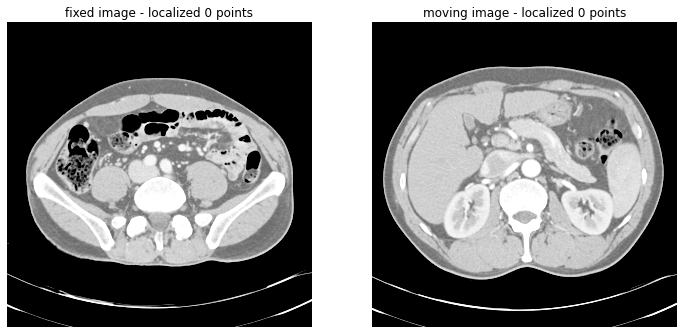

In [41]:
initial_transform = sitk.CenteredTransformInitializer(fixed, 
                                                      moving, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

gui.RegistrationPointDataAquisition(fixed, moving, figure_size = (12,8), 
                                    known_transformation = initial_transform,
                                    fixed_window_level = ct_window_level, 
                                    moving_window_level = ct_window_level
                                    #moving_window_level=mr_window_level);
                                   )

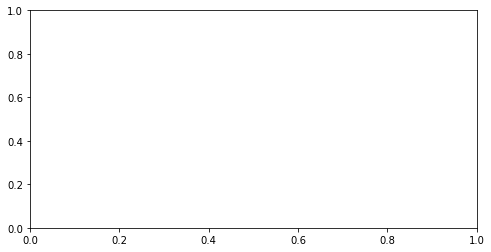

itk::simple::Transform
 CompositeTransform (0x555dbeb57f70)
   RTTI typeinfo:   itk::CompositeTransform<double, 3u>
   Reference Count: 1
   Modified Time: 10052644
   Debug: Off
   Object Name: 
   Observers: 
     none
   Transforms in queue, from begin to end:
   >>>>>>>>>
   Euler3DTransform (0x555dcac435d0)
     RTTI typeinfo:   itk::Euler3DTransform<double>
     Reference Count: 1
     Modified Time: 10052635
     Debug: Off
     Object Name: 
     Observers: 
       none
     Matrix: 
       0.998402 0.000222287 0.0565096 
       -0.00188742 0.999566 0.0294148 
       -0.0564785 -0.0294744 0.997969 
     Offset: [-14.911, -8.92561, -105.022]
     Center: [169.169, 169.169, 215]
     Translation: [-2.99413, -2.99423, -119.999]
     Inverse: 
       0.998402 -0.00188742 -0.0564785 
       0.000222287 0.999566 -0.0294744 
       0.0565096 0.0294148 0.997969 
     Singular: 0
     Euler's angles: AngleX=-0.0294787 AngleY=0.0565332 AngleZ=-0.000222384
     m_ComputeZYX = 0
   End of 

In [46]:
# Handle optimizer
reg = sitk.ImageRegistrationMethod()

reg.SetMetricFixedMask(mask_fixed)
reg.SetMetricMovingMask(mask_moving)

reg.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
reg.SetMetricSamplingStrategy(reg.RANDOM)
reg.SetMetricSamplingPercentage(0.01)
reg.SetInterpolator(sitk.sitkLinear)

# Gradient descent optimizer
reg.SetOptimizerAsRegularStepGradientDescent(learningRate=0.01, minStep=1e-5,
                                             numberOfIterations=250, 
                                             gradientMagnitudeTolerance=1e-8)

reg.SetInitialTransform(initial_transform, inPlace=False)
reg.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
reg.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
reg.AddCommand(sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations) 
reg.AddCommand(sitk.sitkIterationEvent, lambda: rgui.plot_values(reg))
#t = sitk.CenteredTransformInitializer(fixed, moving, sitk.AffineTransform(3))

#reg.SetInitialTransform(t)

outTx = reg.Execute(fixed, moving)

print(outTx)
print("--------")
print("Metric value:{}".format(reg.GetMetricValue()))
print("Optimizer stop condition:{0}".format(reg.GetOptimizerStopConditionDescription()))
print("Number of iterations: {0}".format(reg.GetOptimizerIteration()))
print("--------")

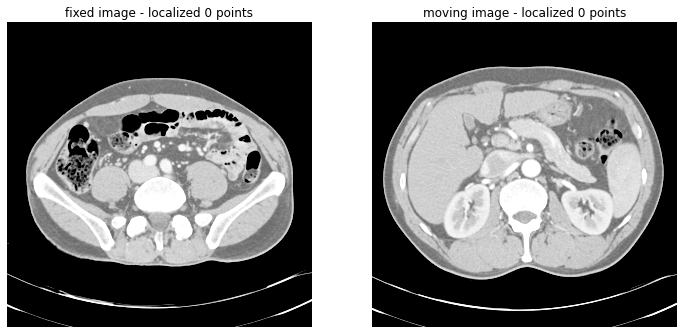

In [47]:
gui.RegistrationPointDataAquisition(fixed, moving, figure_size = (12,8), 
                                    known_transformation = outTx,
                                    fixed_window_level = ct_window_level, 
                                    moving_window_level = ct_window_level);

In [13]:
fixed = sitk.ReadImage(os.path.join(path_fixed_images, "789_40695855_resize.hdr"), sitk.sitkFloat32);
moving = sitk.ReadImage(os.path.join(path_moving_images, "789_40695855_resize.hdr"), sitk.sitkFloat32)
maskFixed = sitk.ReadImage(os.path.join(path_fixed_masks, "789_40695855_resize_Lg.hdr"), sitk.sitkUInt8)
maskMoving= sitk.ReadImage(os.path.join(path_moving_masks, "789_40695855_resize_Lg.hdr"), sitk.sitkUInt8)

# Handle optimizer
R = sitk.ImageRegistrationMethod()

# Restrict the evaluation of the similarity metric thanks to masks
R.SetMetricFixedMask(maskFixed)
R.SetMetricMovingMask(maskMoving)

# Set metric as mutual information using joint histogram
R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=255)

# Gradient descent optimizer
R.SetOptimizerAsRegularStepGradientDescent(learningRate=0.01, minStep=1e-5,
numberOfIterations=10, gradientMagnitudeTolerance=1e-8)

#R.SetOptimizerScalesFromPhysicalShift()

R.SetMetricSamplingStrategy(R.REGULAR) #R.RANDOM

# Define the transformation (Rigid body here)

transf = sitk.CenteredTransformInitializer(fixed, moving,
sitk.Euler3DTransform())

R.SetInitialTransform(transf)

# Define interpolation method
R.SetInterpolator(sitk.sitkLinear)

# Add command to the registration process
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
# R.AddCommand(sitk.sitkStartEvent, lambda: start_plot())
# R.AddCommand(sitk.sitkEndEvent, lambda: end_plot())
# R.AddCommand(sitk.sitkIterationEvent, lambda: current_plot(R))
# Perform registration
outTx = R.Execute(fixed, moving)

print(outTx)
print("--------")
print("Optimizer stop condition:{0}".format(R.GetOptimizerStopConditionDescription()))
print("Number of iterations: {0}".format(R.GetOptimizerIteration()))
print("--------")

# Perform transformation and resample the moving image

# Save transformation as tfm file
sitk.WriteTransform(outTx,'transf_final.tfm')
#sitk.Show(transf.GetDisplacementField(),"Displacement field")

# # Resample moving image according to the last transformation
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)a
#resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)
out = resampler.Execute(moving)
sitk.WriteImage(out, "imsi.mha")

itk::simple::Transform
 Euler3DTransform (0x555dbe8c9d10)
   RTTI typeinfo:   itk::Euler3DTransform<double>
   Reference Count: 3
   Modified Time: 7775217
   Debug: Off
   Object Name: 
   Observers: 
     none
   Matrix: 
     0.995966 0.00163292 0.0897114 
     -0.00408634 0.999622 0.0271711 
     -0.0896332 -0.0274281 0.995597 
   Offset: [-23.0719, 3.19931, -102.28]
   Center: [170.243, 149.842, 220.096]
   Translation: [-3.7687, 8.42732, -122.618]
   Inverse: 
     0.995966 -0.00408634 -0.0896332 
     0.00163292 0.999622 -0.0274281 
     0.0897114 0.0271711 0.995597 
   Singular: 0
   Euler's angles: AngleX=-0.0274315 AngleY=0.0897875 AngleZ=-0.00163353
   m_ComputeZYX = 0

--------
Optimizer stop condition:RegularStepGradientDescentOptimizerv4: Maximum number of iterations (10) exceeded.
Number of iterations: 10
--------
